In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import time
from matplotlib import colors
cmap = colors.ListedColormap(['white', 'red'])

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, BatchNormalization, LeakyReLU
from tensorflow.keras.layers import Conv2DTranspose, Dropout, ReLU, Input, Concatenate, ZeroPadding2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

In [2]:
class Error(Exception):
    """Base class for exceptions in this module."""
    pass

class UnsupportedTypeError(Error):
    """Exception raised for unsupported types.

    Attributes:
        expression -- input expression in which the error occurred
        message -- explanation of the error
    """

    def __init__(self, message):
        self.message = message

class UnsupportedLevelError(Error):
    """Exception raised for unsupported types.

    Attributes:
        expression -- input expression in which the error occurred
        message -- explanation of the error
    """

    def __init__(self, message):
        self.message = message

In [3]:
def change_destruction_level(image, destruction_level):
    """
    Changes the destruction level of a pre_disaster mask to create a post_disaster_mask.
    
    Parameters
    ----------
    image : numpy.ndarray or Tensorflow Tensor
        Contains the image of the pre disaster mask
    destruction_level : str or int
        Level of destruction to be created from the pre disaster mask
    
    Returns
    -------
    numpy.ndarray or Tensorflow Tensor
        A Tensor or numpy array to signify a post disaster mask
    
    Raises
    ------
    UnsupportedLevelError
        Raised when the user provides a destruction level that isn't supported
    UnsupportedTypeError
        Raised when the user provides the destruction level that isn't a string or an integer
        Raised when the user provides an image that isn't a numpy array or a Tensorflow Tensor
    """
    destruction_levels = {
        "no damage": 1,
        "minor": 2,
        "major": 3,
        "destroyed": 4
    }
    
    if isinstance(destruction_level, str):
        try:
            destruction_level = destuction_levels[destruction_level]
        except KeyError:
            raise UnsupportedLevelError(f"{destruction_level} is not a supported destruction level. The only supported string levels are 'no damage', 'minor', 'major', and 'destroyed'.")
    elif isinstance(destruction_level, int):
        if destruction_level > 4 or destruction_level < 1:
            raise UnsupportedLevelError(f"{destruction_level} is not a supported destruction level. The only supported integer levels are 1, 2, 3, and 4.")
    else:
        raise UnsupportedTypeError("Destruction level must be a string or an integer.")
    
    if isinstance(image, np.ndarray):
        return np.where(image != 0, destruction_level, image).astype(np.float32)
    elif tf.is_tensor(image):
        return tf.cast(tf.where(image != 0, destruction_level, image), tf.float32)
    else:
        raise UnsupportedTypeError("This function only supports Tensors and numpy.ndarray objects.")

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
gan_one = tf.keras.models.load_model("drive/My Drive/Colab Notebooks/modified_data/pre_and_post_joined/saved_modelsB/generator/gen_model_1775.h5")
gan_two = tf.keras.models.load_model("drive/My Drive/Colab Notebooks/modified_data/pre_and_post_joined/saved_modelsC/generator/gen_model_500.h5")

gan_one.compile()
gan_two.compile()

In [6]:
DATA_PATH = "/content/drive/My Drive/Colab Notebooks/rdata512"
# Train Paths
pre_image_path_train = DATA_PATH + "/train_pre/images" #input_1
masks_path_train = DATA_PATH + "/train_post/targets"   # input_2
post_image_path_train = DATA_PATH + "/train_post/images" # target

train_pre_images_names = !ls -1 "{pre_image_path_train}"
train_masks_names = !ls -1 "{masks_path_train}"
train_post_images_names = !ls -1 "{post_image_path_train}"

train_pre_images_names = sorted(train_pre_images_names)
train_masks_names = sorted(train_masks_names)
train_post_images_names = sorted( train_post_images_names)



In [7]:
print( f" len of train_pre_images_names = {len(train_pre_images_names)}" )
print( train_pre_images_names[:3] )

print( f"\n\nlen of train_masks_names = {len(train_masks_names)}" )
print( train_masks_names[:3] )

print( f"\n\nlen of train_post_images_names = {len(train_post_images_names)}" )
print( train_post_images_names[:3] )

 len of train_pre_images_names = 2799
['guatemala-volcano_00000000_pre_disaster.png', 'guatemala-volcano_00000001_pre_disaster.png', 'guatemala-volcano_00000002_pre_disaster.png']


len of train_masks_names = 2799
['guatemala-volcano_00000000_post_disaster_target.png', 'guatemala-volcano_00000001_post_disaster_target.png', 'guatemala-volcano_00000002_post_disaster_target.png']


len of train_post_images_names = 2799
['guatemala-volcano_00000000_post_disaster.png', 'guatemala-volcano_00000001_post_disaster.png', 'guatemala-volcano_00000002_post_disaster.png']


In [8]:
IMAGE_SIZE = 256

# Resize image function
def resize( input_image,target_image, image_size = IMAGE_SIZE):
  input_image = tf.image.resize(input_image, [image_size, image_size], method = tf.image.ResizeMethod.NEAREST_NEIGHBOR )
  target_image = tf.image.resize( target_image, [image_size, image_size], method = tf.image.ResizeMethod.NEAREST_NEIGHBOR )

  return input_image, target_image


# Normalize images [0,254] to [-1,+1]
def normalize(input_image, target_image):
  input_image  =  (input_image/127.5) - 1
  target_image  =  (target_image/127.5) - 1

  return input_image, target_image 


# Augmentation of data: Random Crop + flip
def random_jitter( input_image, target_image ):

  input_image, target_image = resize( input_image, target_image, 286 )

  stacked_image = tf.stack( [input_image, target_image], axis = 0 )
  cropped_image = tf.image.random_crop( stacked_image, size = [2, IMAGE_SIZE, IMAGE_SIZE, 4] )

  input_image, target_image = cropped_image[0], cropped_image[1]


  return input_image, target_image


In [9]:
def load_image(filename, augment = True, from_training = True, destruction_level = 3):
  '''
   input1 := Pre-image
   input2 := Mask post-image

   target := Post image
  '''
  if len( tf.strings.split(filename, sep = "pre") ) == 2 :
    filename_input1 = tf.strings.split( filename, sep = "pre" )[0] + 'pre' + tf.strings.split( filename, sep = "pre" )[-1]
    filename_target = tf.strings.split( filename, sep = "pre" )[0] + 'post' + tf.strings.split( filename, sep = "pre" )[-1]
    filename_input2 = tf.strings.split( filename_target, sep = ".png")[0] + "_target.png" 

  elif len( tf.strings.split( filename, sep = "post") ) == 2: 
    filename_input1  =  tf.strings.split( filename, sep = "post" )[0] + 'pre' + tf.strings.split( filename, sep = "post" )[-1]
    filename_target  =  tf.strings.split( filename, sep = "post" )[0] + 'post' + tf.strings.split( filename, sep = "post" )[-1]
    filename_input2  =  tf.strings.split( filename_target, sep = ".png")[0] + "_target.png"
  else:
    filename_input1 = ""
    filename_input2 = ""
    filename_target = ""


  if from_training:
    pre_image  = tf.cast( tf.image.decode_png( tf.io.read_file( pre_image_path_train + '/'  + filename_input1 ), channels = 3 ), tf.float32)
    mask_image  = tf.cast( tf.image.decode_png( tf.io.read_file( masks_path_train + '/'  + filename_input2 ), channels = 1 ), tf.float32)
    
    target_image = tf.cast( tf.image.decode_png( tf.io.read_file(  post_image_path_train + '/' + filename_target ), channels = 4 ), tf.float32)
  else:
    pre_image  = tf.cast( tf.image.decode_png( tf.io.read_file( pre_image_path_test + '/'  + filename_input1 ), channels = 3 ), tf.float32)
    mask_image  = tf.cast( tf.image.decode_png( tf.io.read_file( masks_path_test + '/'  + filename_input2 ), channels = 1 ), tf.float32)

    target_image = tf.cast( tf.image.decode_png( tf.io.read_file(  post_image_path_test + '/' + filename_target ), channels = 4 ), tf.float32)



  modified_mask = change_destruction_level(mask_image, destruction_level )
  new_input = tf.experimental.numpy.dstack( (modified_mask, pre_image) )

  new_input, target_image = resize( new_input, target_image, IMAGE_SIZE)
  
  if augment:
      new_input, target_image = random_jitter( new_input, target_image)
  
  new_input, target_image = normalize( new_input, target_image)

  

  pre_image, mask_image = resize( pre_image, mask_image, IMAGE_SIZE)
  
  
  target_image, unused_channel = tf.experimental.numpy.split(
                                                              target_image, [3],  axis=-1
                                                            )
 

  
  

  return pre_image, mask_image, modified_mask ,new_input, target_image


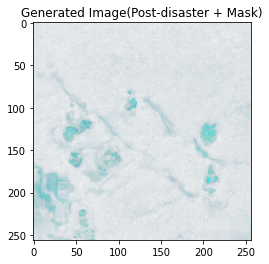

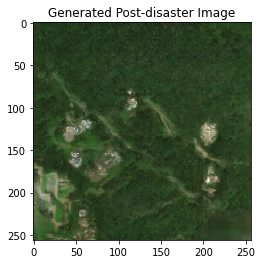

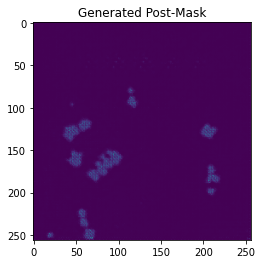

In [10]:
destruction_level = 2


example_pre,example_mask, example_mask_modified, example_input, example_target = load_image(train_pre_images_names[12], destruction_level)


generated_post = gan_two( tf.expand_dims(example_input,axis = 0), training = True  )




plt.imshow( tf.squeeze(generated_post)*0.5 + 0.5  )
plt.title("Generated Image(Post-disaster + Mask)")
plt.show()



generated_mask_07, generated_post_separated = tf.experimental.numpy.split( generated_post, [1], axis = 3)

plt.imshow( tf.squeeze(generated_post_separated)*0.5 + 0.5 )
plt.title('Generated Post-disaster Image')
plt.show()



plt.imshow( tf.squeeze(generated_mask_07)*0.5 + 0.5 )
plt.title('Generated Post-Mask')
plt.show()

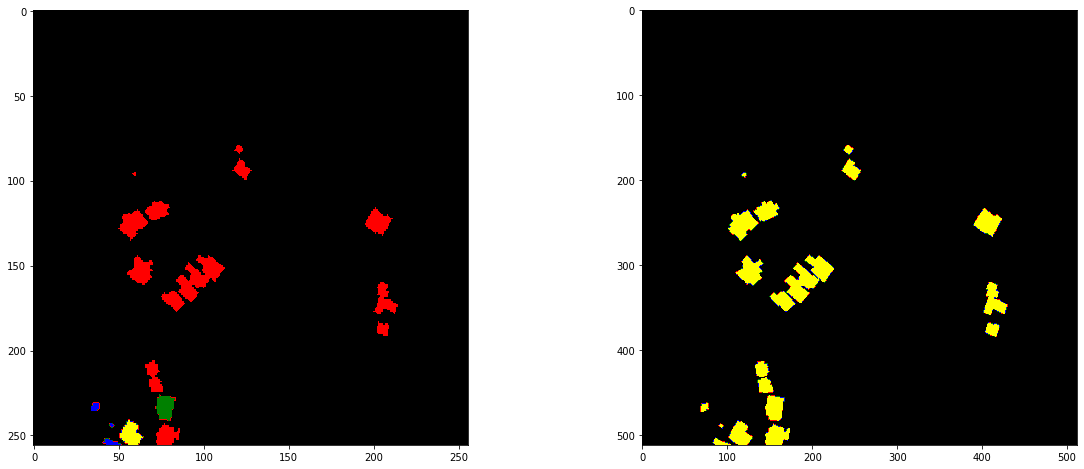

In [11]:
cmap = colors.ListedColormap(['black', 'red', 'green', 'blue', 'yellow'])
fig, axes = plt.subplots(1,2, figsize = (20,8))
axes[0].imshow( tf.squeeze(example_mask)*0.5 + 0.5, cmap = cmap )
axes[1].imshow( tf.squeeze(example_mask_modified)*0.5 + 0.5, cmap = cmap)
plt.show()

In [12]:
def generate_post_images( pre_image_filename, destruction_level = 0, model = gan_one):
  
  pre_image, old_mask, mask_modified, new_input, target_image = load_image( filename = pre_image_filename, destruction_level = destruction_level)


  generated_post = model( tf.expand_dims(new_input, axis = 0 ), training = True )


  cmap1 = colors.ListedColormap(['black', 'red', 'green', 'blue', 'yellow'])
  
  if destruction_level == 0:
     cmap2 = colors.ListedColormap(['black', 'red', 'green', 'blue', 'yellow'])
  elif destruction_level == 1:
     cmap2 = colors.ListedColormap(['black', 'red']) 
  elif destruction_level == 2:
     cmap2 = colors.ListedColormap(['black', 'green'])
  elif destruction_level == 3:
     cmap2 = colors.ListedColormap(['black', 'blue'])
  elif destruction_level == 4:
     cmap2 = colors.ListedColormap(['black', 'yellow'])
     
  
  
  if model == gan_one:
    
    print( f'Pre-Image = {pre_image_filename}')
    fig, axes = plt.subplots(1,5, figsize = (20,8))
    axes[0].imshow( pre_image/255    )
    axes[1].imshow( tf.squeeze(old_mask)*0.5 + 0.5, cmap = cmap1 )
    axes[2].imshow( tf.squeeze(mask_modified)*0.5 + 0.5, cmap = cmap2 )
    axes[3].imshow( new_input*0.5 + 0.5)
    axes[4].imshow( tf.squeeze(generated_post)*0.5 + 0.5)
    axes[0].title.set_text( 'Pre-Image' )
    axes[1].title.set_text( 'Old Mask-Image') 
    axes[2].title.set_text( f'Mask-Image (level of destruction = {destruction_level})' )  
    axes[3].title.set_text( 'New Input')
    axes[4].title.set_text( 'Generated Post-Image' )

    axes[0].axis("off")
    axes[1].axis("off")
    axes[2].axis("off")
    axes[3].axis("off")
    axes[4].axis("off")


  else:
    generated_mask_, generated_post_separated = tf.experimental.numpy.split( generated_post, [1],  axis = -1 )
    cmap3 = colors.ListedColormap(['black', 'blue'])
          
    
    print( f'Pre-Image = {pre_image_filename}')
    fig, axes = plt.subplots(1,6, figsize = (20,8))
    axes[0].imshow( pre_image/255    )
    axes[1].imshow(  tf.squeeze(mask_modified)*0.5 + 0.5, cmap = cmap2 )
    axes[2].imshow( tf.squeeze(generated_post_separated)*0.5 + 0.5)
    axes[3].imshow(tf.squeeze(generated_mask_)*0.5 + 0.5, cmap = cmap1  )
    axes[4].imshow(  (tf.squeeze(old_mask) + 1)*255, cmap = cmap1 )
    axes[5].imshow(  tf.squeeze(generated_post)*0.5 + 0.5)
    
    
    axes[0].title.set_text( 'Pre-Image' )
    axes[1].title.set_text(  f'Input Mask(level of destruction = {destruction_level})' )
    axes[2].title.set_text( 'Generated Post-Image' )
    axes[3].title.set_text( 'Generated Mask' )
    axes[4].title.set_text(  'Old Mask-Image') 
    axes[5].title.set_text( 'Generated Post-Image + Mask' )

    axes[0].axis("off")
    axes[1].axis("off")
    axes[2].axis("off")
    axes[3].axis("off")
    axes[4].axis("off")
    axes[5].axis("off")
    
    plt.show()

  



In [13]:
gan_one = tf.keras.models.load_model("drive/My Drive/Colab Notebooks/modified_data/pre_and_post_joined/saved_modelsB/generator/gen_model_1775.h5")
gan_two = tf.keras.models.load_model("drive/My Drive/Colab Notebooks/modified_data/pre_and_post_joined/saved_modelsC/generator/gen_model_500.h5")

gan_one.compile()
gan_two.compile()

Pre-Image = guatemala-volcano_00000019_pre_disaster.png
Pre-Image = guatemala-volcano_00000019_pre_disaster.png
Pre-Image = guatemala-volcano_00000019_pre_disaster.png
Pre-Image = guatemala-volcano_00000019_pre_disaster.png


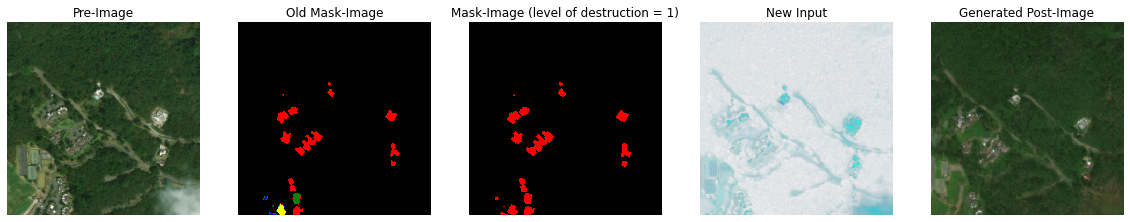

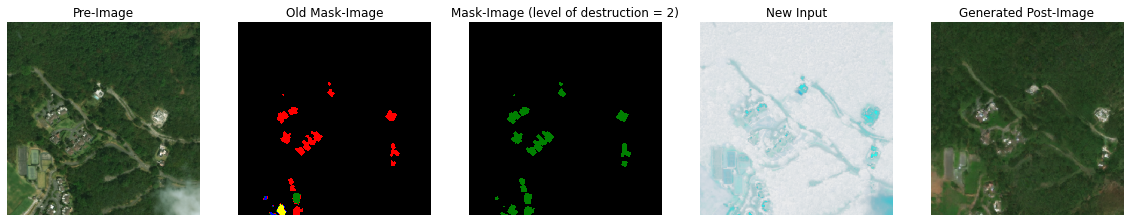

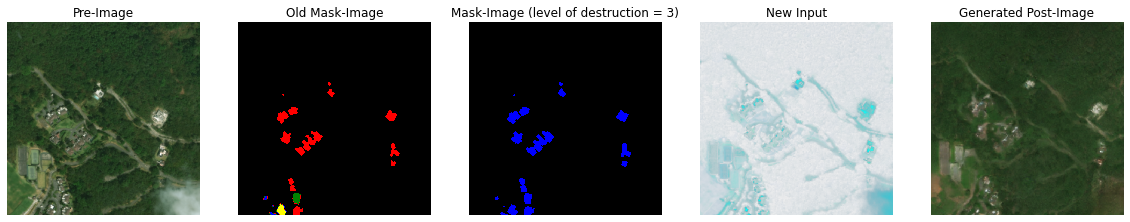

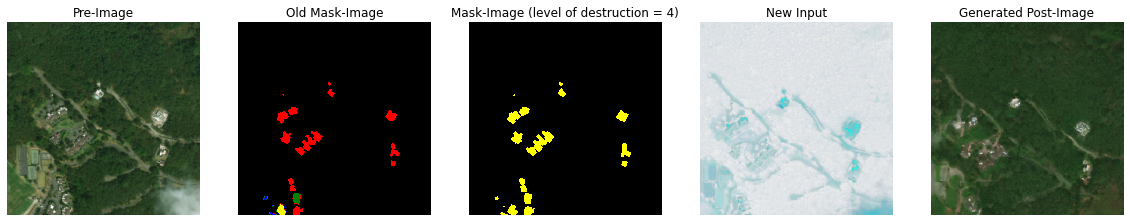

In [14]:
# running samples for GAN-1
for i in range(1,4+1):
  generate_post_images(train_pre_images_names[12], destruction_level = i, model = gan_one) 

Pre-Image = guatemala-volcano_00000019_pre_disaster.png


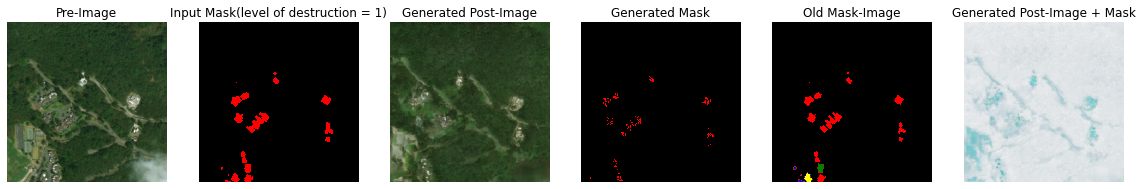

Pre-Image = guatemala-volcano_00000019_pre_disaster.png


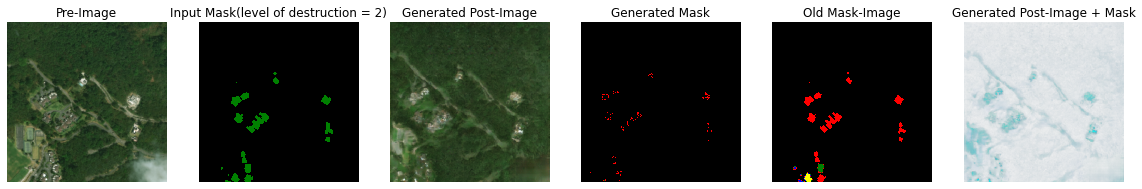

Pre-Image = guatemala-volcano_00000019_pre_disaster.png


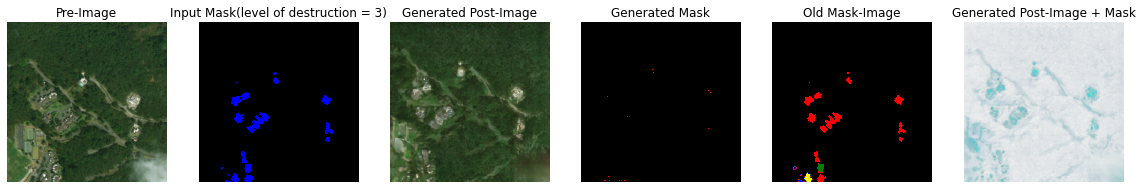

Pre-Image = guatemala-volcano_00000019_pre_disaster.png


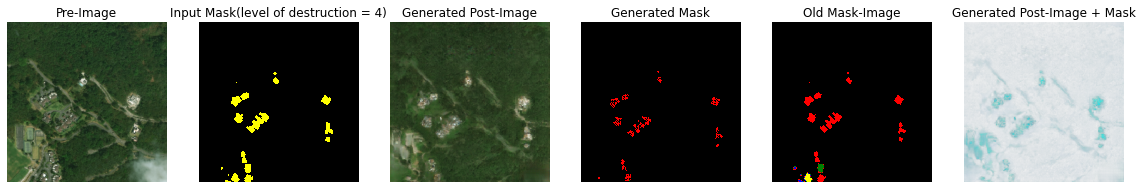

In [15]:
# running samples for GAN-2
for i in range(1,4+1):
  generate_post_images(train_pre_images_names[12], destruction_level = i, model = gan_two) 